# EECS 498-007/598-005 Assignment 1-2: K-Nearest Neighbors (k-NN)

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Your NAME, #XXXXXXXX

In this notebook you will implement a K-Nearest Neighbors classifier on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Recall that the K-Nearest Neighbor classifier does the following:
- During training, the classifier simply memorizes the training data
- During testing, test images are compared to each training image; the predicted label is the majority vote among the K nearest training examples.

After implementing the K-Nearest Neighbor classifier, you will use *cross-validation* to find the best value of K.

The goals of this exercise are to go through a simple example of the data-driven image classification pipeline, and also to practice writing efficient, vectorized code in [PyTorch](https://pytorch.org/).

# Setup Code
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['pytorch101.py', 'knn.py', 'knn.ipynb', 'eecs598', 'pytorch101.ipynb']
```

In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2020FA folder and put all the files under A1 folder, then '2020FA/A1'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2020FA/A1'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from knn.py!
```

as well as the last edit time for the file `pytorch101.py`.

In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from knn import hello
hello()

knn_path = os.path.join(GOOGLE_DRIVE_PATH, 'pytorch101.py')
knn_edit_time = time.ctime(os.path.getmtime(knn_path))
print('knn.py last edited on %s' % knn_edit_time)

# Data preprocessing / Visualization

## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [1]:
import eecs598
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics

plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置图像显示大小
plt.rcParams['font.size'] = 16 # 设置字体大小

## Load the CIFAR-10 dataset
The utility function `eecs598.data.cifar10()` returns the entire CIFAR-10 dataset as a set of four **Torch tensors**:

- `x_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `x_test` contains all test images
- `y_test` contains all test labels

This function automatically downloads the CIFAR-10 dataset the first time you run it.

In [17]:
x_train, y_train, x_test, y_test = eecs598.data.cifar10()

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Test set:')
print('  data shape: ', x_test.shape)
print('  labels shape', y_test.shape)

Training set:
  data shape: torch.Size([50000, 3, 32, 32])
  labels shape:  torch.Size([50000])
Test set:
  data shape:  torch.Size([10000, 3, 32, 32])
  labels shape torch.Size([10000])


## Visualize the dataset
To give you a sense of the nature of the images in CIFAR-10, this cell visualizes some random examples from the training set.

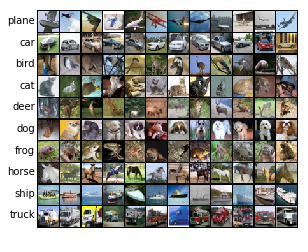

In [3]:
import random
from torchvision.utils import make_grid

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 12
samples = []
for y, cls in enumerate(classes): # enumerate()函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据下标和数据，一般用在for循环当中
    plt.text(-4, 34 * y+20 , cls, ha='right')  # 添加图形内容细节的无指向型注释文本,在本例中用于添加左边的类别注释，可更改参数观察
    idxs, = (y_train == y).nonzero(as_tuple=True) # 取出非零元素对应的索引，在本例中是取出训练集类别与当前类别一致的索引
    for i in range(samples_per_class):
        idx = idxs[random.randrange(idxs.shape[0])].item() # randrange()返回从指定范围内随机选择的元素，本例循环执行12次，每次从类别一致的数目中抽调1个，并将该图赋给样本列表，.item()使返回一个数字而不是tensor
        samples.append(x_train[idx])
img = torchvision.utils.make_grid(samples, nrow=samples_per_class) # 参数nrow代表每一行的图像个数
plt.imshow(eecs598.tensor_to_image(img))
plt.axis('off') # 关闭坐标轴
plt.show()

## Subsample the dataset
When implementing machine learning algorithms, it's usually a good idea to use a small sample of the full dataset. This way your code will run much faster, allowing for more interactive and efficient development. Once you are satisfied that you have correctly implemented the algorithm, you can then rerun with the entire dataset.

The function `eecs598.data.cifar10()` can automatically subsample the CIFAR10 dataset for us. To see how to use it, we can check the documentation using the built-in `help` command:

In [26]:
help(eecs598.data.cifar10)

Help on function cifar10 in module eecs598.data:

cifar10(num_train=None, num_test=None)
    Return the CIFAR10 dataset, automatically downloading it if necessary.
    This function can also subsample the dataset.
    
    Inputs:
    - num_train: [Optional] How many samples to keep from the training set.
      If not provided, then keep the entire training set.
    - num_test: [Optional] How many samples to keep from the test set.
      If not provided, then keep the entire test set.
    
    Returns:
    - x_train: float32 tensor of shape (num_train, 3, 32, 32)
    - y_train: int64 tensor of shape (num_train, 3, 32, 32)
    - x_test: float32 tensor of shape (num_test, 3, 32, 32)
    - y_test: int64 tensor of shape (num_test, 3, 32, 32)



We will subsample the data to use only 500 training examples and 100 test examples:

In [27]:
num_train = 500
num_test = 250

x_train, y_train, x_test, y_test = eecs598.data.cifar10(num_train, num_test)

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Test set:')
print('  data shape: ', x_test.shape)
print('  labels shape', y_test.shape)

Training set:
  data shape: torch.Size([500, 3, 32, 32])
  labels shape:  torch.Size([500])
Test set:
  data shape:  torch.Size([250, 3, 32, 32])
  labels shape torch.Size([250])


# K-Nearest Neighbors (k-NN)

## Compute distances: Naive implementation
Now that we have examined and prepared our data, it is time to implement the kNN classifier. We can break the process down into two steps:

1. Compute the (squared Euclidean) distances between all training examples and all test examples
2. Given these distances, for each test example find its k nearest neighbors and have them vote for the label to output

Lets begin with computing the distance matrix between all training and test examples. First we will implement a naive version of the distance computation, using explicit loops over the training and test sets. In the file `knn.py`, implement the function `compute_distances_two_loops`.

**NOTE: When implementing distance functions for this assignment, you may not use functions `torch.norm` or `torch.dist` (or their instance method variants `x.norm` / `x.dist`); you may not use any functions from `torch.nn` or `torch.nn.functional`.**

In [4]:
def compute_distances_two_loops(x_train, x_test):
    num_train = x_train.shape[0]
    num_test = x_test.shape[0]
    dists = x_train.new_zeros(num_train, num_test)
    x_train_flatten = x_train.clone().reshape(num_train, -1)
    x_test_flatten = x_test.clone().reshape(num_test, -1)
    for i in range(num_test):
        for j in range(num_train):
            dists[j, i] = torch.sum((x_test_flatten[i] - x_train_flatten[j])**2)
    return dists

In [34]:
# test
x_train, y_train, x_test, y_test = eecs598.data.cifar10(2, 2)
tr_flat = x_train.clone().reshape(2, -1)
te_flat = x_test.clone().reshape(2, -1)
print(tr_flat)
print(te_flat)
dists = x_train.new_zeros(2, 2)
for i in range(2):
    for j in range(2):
        dists[i, j] = torch.sum((tr_flat[i] - te_flat[j])**2)
    
print(dists)

tensor([[0.2314, 0.1686, 0.1961,  ..., 0.5490, 0.3294, 0.2824],
        [0.6039, 0.4941, 0.4118,  ..., 0.5451, 0.5569, 0.5647]])
tensor([[0.6196, 0.6235, 0.6471,  ..., 0.4863, 0.5059, 0.4314],
        [0.9216, 0.9059, 0.9098,  ..., 0.6980, 0.7490, 0.7804]])
tensor([[222.5272, 617.5388],
        [272.6508, 427.1565]])


In [17]:
torch.manual_seed(0)  #为CPU中设置种子，确保每次生成的随机数是固定的
num_train = 500
num_test = 250
x_train, y_train, x_test, y_test = eecs598.data.cifar10(num_train, num_test)

dists = compute_distances_two_loops(x_train, x_test)
print('dists has shape: ', dists.shape)
print(dists)

dists has shape:  torch.Size([500, 250])
tensor([[222.5272, 617.5388, 419.8223,  ..., 366.5119, 168.7971, 347.3957],
        [272.6508, 427.1565, 277.8618,  ..., 250.0619, 222.1277, 557.7333],
        [465.8918, 251.0841, 219.0337,  ..., 197.1521, 425.7546, 928.1519],
        ...,
        [381.8001, 241.5052, 251.2128,  ..., 214.9345, 298.6783, 972.7269],
        [364.3431, 335.6879, 337.6084,  ..., 234.4238, 298.9630, 838.0011],
        [238.9443, 418.5836, 279.6165,  ..., 261.1116, 233.5973, 488.9242]])


As a visual debugging step, we can visualize the distance matrix, where each row is a test example and each column is a training example.

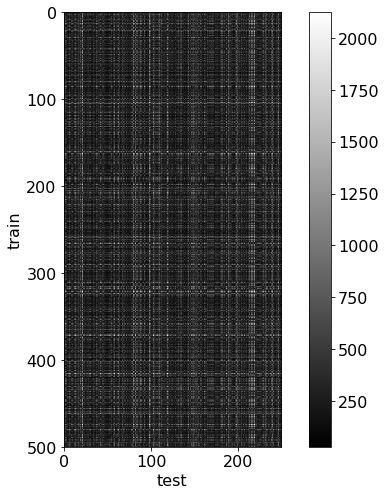

In [37]:
plt.imshow(dists.numpy(), cmap='gray', interpolation='none')
plt.colorbar()
plt.xlabel('test')
plt.ylabel('train')
plt.show()

## Compute distances: Vectorization
Our implementation of the distance computation above is fairly inefficient since it uses nested Python loops over the training and test sets.

When implementing algorithms in PyTorch, it's best to avoid loops in Python if possible. Instead it is preferable to implement your computation so that all loops happen inside PyTorch functions. This will usually be much faster than writing your own loops in Python, since PyTorch functions can be internally optimized to iterate efficiently, possibly using multiple threads. This is especially important when using a GPU to accelerate your code.

The process of eliminating explict loops from your code is called **vectorization**. Sometimes it is straighforward to vectorize code originally written with loops; other times vectorizing requires thinking about the problem in a new way. We will use vectorization to improve the speed of our distance computation function.

As a first step toward vectorizing our distance computation, you will implement a version that uses only a single Python loop over the training data. In the file `knn.py`, complete the implementation of the function `compute_distances_one_loop`.

We can check the correctness of our one-loop implementation by comparing it with our two-loop implementation on some randomly generated data.

Note that we do the comparison with 64-bit floating points for increased numeric precision.

In [5]:
def compute_distances_one_loop(x_train, x_test):
    num_train = x_train.shape[0]
    num_test = x_test.shape[0]
    dists = x_train.new_zeros(num_train, num_test)
    x_train_flatten = x_train.clone().reshape(num_train, -1)
    x_test_flatten = x_test.clone().reshape(num_test, -1)
    for i in range(num_test):
        dists[:, i] = torch.sum((x_train_flatten - x_test_flatten[i])**2, dim = 1)
    return dists

In [23]:
import torch
import random
torch.manual_seed(1)
x1 = torch.randn(2, 3)
x2 = torch.randn(2, 3)
print(x1)
print(x2)
torch.manual_seed(1)
x3 = torch.randn(2, 3)
x4 = torch.rand(2, 3)
print(x3)
print(x4)
torch.manual_seed(1)
print(torch.rand(2, 3))
torch.manual_seed(1)
print(torch.rand(2, 3))
torch.manual_seed(0)
print(random.random())
torch.manual_seed(0)
print(random.random())
random.seed(1)
print(random.random())
random.seed(1)
print(random.random())

tensor([[ 0.6614,  0.2669,  0.0617],
        [ 0.6213, -0.4519, -0.1661]])
tensor([[-1.5228,  0.3817, -1.0276],
        [-0.5631, -0.8923, -0.0583]])
tensor([[ 0.6614,  0.2669,  0.0617],
        [ 0.6213, -0.4519, -0.1661]])
tensor([[0.6826, 0.3051, 0.4635],
        [0.4550, 0.5725, 0.4980]])
tensor([[0.7576, 0.2793, 0.4031],
        [0.7347, 0.0293, 0.7999]])
tensor([[0.7576, 0.2793, 0.4031],
        [0.7347, 0.0293, 0.7999]])
0.7579544029403025
0.420571580830845
0.13436424411240122
0.13436424411240122


In [22]:
import torch


print(torch.randn(1, 2))


print(torch.randn(1, 2))

tensor([[ 0.1604, -0.6065]])
tensor([[-0.7831,  1.0622]])


In [62]:
torch.manual_seed(0)  #为CPU中设置种子，确保每次生成的随机数是固定的，即每次重新调用torch.manual_seed(0)后，生成的随机数一样
x_train_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)
x_test_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)

dists_one = compute_distances_one_loop(x_train_rand, x_test_rand)
dists_two = compute_distances_two_loops(x_train_rand, x_test_rand)
print(dists_one)
print(dists_two)
difference = (dists_one - dists_two).pow(2).sum().sqrt().item()
print('Difference: ', difference)
if difference < 1e-4:
    print('Good! The distance matrices match')
else:
    print('Uh-oh! The distance matrices are different')

tensor([[1545.7575, 1584.9773, 1624.9240,  ..., 1682.9842, 1466.7671,
         1567.1689],
        [1511.8026, 1396.4353, 1453.9622,  ..., 1478.6000, 1562.6354,
         1441.0420],
        [1504.0319, 1643.5523, 1555.8778,  ..., 1600.6995, 1675.4076,
         1376.0648],
        ...,
        [1429.3707, 1494.3544, 1557.3122,  ..., 1603.7456, 1499.9324,
         1524.3555],
        [1445.2597, 1476.2096, 1548.9070,  ..., 1512.9424, 1596.0464,
         1462.5432],
        [1469.5399, 1477.5540, 1495.6123,  ..., 1632.8872, 1543.1241,
         1479.6518]], dtype=torch.float64)
tensor([[1545.7575, 1584.9773, 1624.9240,  ..., 1682.9842, 1466.7671,
         1567.1689],
        [1511.8026, 1396.4353, 1453.9622,  ..., 1478.6000, 1562.6354,
         1441.0420],
        [1504.0319, 1643.5523, 1555.8778,  ..., 1600.6995, 1675.4076,
         1376.0648],
        ...,
        [1429.3707, 1494.3544, 1557.3122,  ..., 1603.7456, 1499.9324,
         1524.3555],
        [1445.2597, 1476.2096, 1548.9070, 

You will now implement a fully vectorized version of the distance computation function
that does not use any Python loops. In the file `knn.py`, implement the function `compute_distances_no_loops`.

As before, we can check the correctness of our implementation by comparing the fully vectorized version against the original naive version:

In [18]:
def compute_distances_no_loops(x_train, x_test):
    num_train = x_train.shape[0]
    num_test = x_test.shape[0]
    dists = x_train.new_zeros(num_train, num_test)
    x_train_flatten = x_train.reshape(num_train, -1)
    x_test_flatten = x_test.reshape(num_test, -1)    
    dists = -2*torch.mm(x_train_flatten, x_test_flatten.t()) + torch.sum(x_test_flatten**2, dim = 1)+torch.sum(x_train_flatten**2, dim = 1).reshape(-1, 1)
    return dists

In [7]:
torch.manual_seed(0)
x_train_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)
x_test_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)

dists_two = compute_distances_two_loops(x_train_rand, x_test_rand)
dists_none = compute_distances_no_loops(x_train_rand, x_test_rand)
print(dists_two)
print(dists_none)
difference = (dists_two - dists_none).pow(2).sum().sqrt().item()
print('Difference: ', difference)
if difference < 1e-4:
  print('Good! The distance matrices match')
else:
  print('Uh-oh! The distance matrices are different')

tensor([[1545.7575, 1584.9773, 1624.9240,  ..., 1682.9842, 1466.7671,
         1567.1689],
        [1511.8026, 1396.4353, 1453.9622,  ..., 1478.6000, 1562.6354,
         1441.0420],
        [1504.0319, 1643.5523, 1555.8778,  ..., 1600.6995, 1675.4076,
         1376.0648],
        ...,
        [1429.3707, 1494.3544, 1557.3122,  ..., 1603.7456, 1499.9324,
         1524.3555],
        [1445.2597, 1476.2096, 1548.9070,  ..., 1512.9424, 1596.0464,
         1462.5432],
        [1469.5399, 1477.5540, 1495.6123,  ..., 1632.8872, 1543.1241,
         1479.6518]], dtype=torch.float64)
tensor([[1545.7575, 1584.9773, 1624.9240,  ..., 1682.9842, 1466.7671,
         1567.1689],
        [1511.8026, 1396.4353, 1453.9622,  ..., 1478.6000, 1562.6354,
         1441.0420],
        [1504.0319, 1643.5523, 1555.8778,  ..., 1600.6995, 1675.4076,
         1376.0648],
        ...,
        [1429.3707, 1494.3544, 1557.3122,  ..., 1603.7456, 1499.9324,
         1524.3555],
        [1445.2597, 1476.2096, 1548.9070, 

We can now compare the speed of our three implementations. If you've implemented everything properly, the one-loop implementation should take less than 4 seconds to run, and the fully vectorized implementation should take less than 0.1 seconds to run.

In [70]:
import time
def timeit(f, *args):
    tic = time.time()
    f(*args) 
    toc = time.time()
    return toc - tic

torch.manual_seed(0)
x_train_rand = torch.randn(500, 3, 32, 32)
x_test_rand = torch.randn(500, 3, 32, 32)

two_loop_time = timeit(compute_distances_two_loops, x_train_rand, x_test_rand)
print('Two loop version took %.2f seconds' % two_loop_time)

one_loop_time = timeit(compute_distances_one_loop, x_train_rand, x_test_rand)
speedup = two_loop_time / one_loop_time
print('One loop version took %.2f seconds (%.1fX speedup)'
      % (one_loop_time, speedup))

no_loop_time = timeit(compute_distances_no_loops, x_train_rand, x_test_rand)
speedup = two_loop_time / no_loop_time
print('No loop version took %.2f seconds (%.1fX speedup)'
      % (no_loop_time, speedup))

Two loop version took 9.85 seconds
One loop version took 2.17 seconds (4.5X speedup)
No loop version took 0.02 seconds (549.0X speedup)


## Predict labels
Now that we have a method for computing distances between training and test examples, we need to implement a function that uses those distances together with the training labels to predict labels for test samples.

In the file `knn.py`, implement the function `predict_labels`.

In [ ]:
# 自己尝试，没写出来
def predict_labels(dists, y_train, k = 1):
    num_train, num_test = dists.shape
    y_pred = torch.zeros(num_test, dtype = torch.int64)
    dists_argsort = torch.argsort(dists, dim = 0)
    dists_k_arg = dists_argsort[0:k, :]
    test_k_class = torch.zeros(k, num_test, dtype = torch.int64)
    for i in range(num_test):
        test_k_class[:, i] = y_train[dists_k_arg[:, i]]
    # 如何求出每一列中出现次数最多的元素？
    return y_pred

In [19]:
def predict_labels(dists, y_train, k = 1):
    num_train, num_test = dists.shape
    y_pred = torch.zeros(num_test, dtype = torch.int64)
    _, idx = torch.topk(dists, k, dim = 0, largest = False)
    for i in range(num_test):
        k_nearest = y_train[idx[:, i]]
        y_pred[i], _ = torch.mode(k_nearest)# 求众数
    return y_pred

In [26]:
torch.manual_seed(0)
dists = torch.tensor([
    [0.3, 0.4, 0.1],
    [0.1, 0.5, 0.5],
    [0.4, 0.1, 0.2],
    [0.2, 0.2, 0.4],
    [0.5, 0.3, 0.3],
])
y_train = torch.tensor([0, 1, 0, 1, 2])
y_pred_expected = torch.tensor([1, 0, 0])
y_pred = predict_labels(dists, y_train, k=3)
correct = y_pred.tolist() == y_pred_expected.tolist()
print('Correct: ', correct)

Correct:  True


Now we have implemented all the required functionality for the K-Nearest Neighbor classifier. In the file `knn.py`, complete the implementation of the `KnnClassifer` class.

We can get some intuition into the KNN classifier by visualizing its predictions on toy 2D data. Here we will generate some random training and test points in 2D, and assign random labels to the training points. We can then make predictions for the test points, and visualize both training and test points. Training points are shown as stars, and tet points are shown as small transparent circles. The color of each point denots its label -- ground-truth label for training points, and predicted label for test points.

In [20]:
class KnnClassifier:
    def __init__(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train

    def predict(self, x_test, k=1):
        y_test_pred = None
        dists = compute_distances_no_loops(self.x_train, x_test)
        y_test_pred = predict_labels(dists, self.y_train, k)
        return y_test_pred
    
    def check_accuracy(self, x_test, y_test, k=1, quiet=False):
        y_test_pred = self.predict(x_test, k=k)
        num_samples = x_test.shape[0]
        num_correct = (y_test == y_test_pred).sum().item()
        accuracy = 100.0 * num_correct / num_samples
        msg = (f'Got {num_correct} / {num_samples} correct; '
               f'accuracy is {accuracy:.2f}%')
        if not quiet:
            print(msg)
        return accuracy

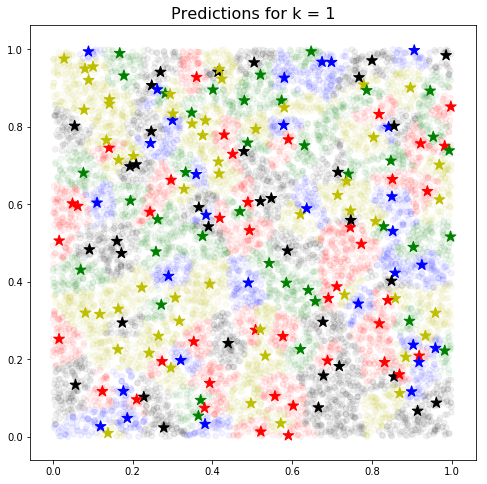

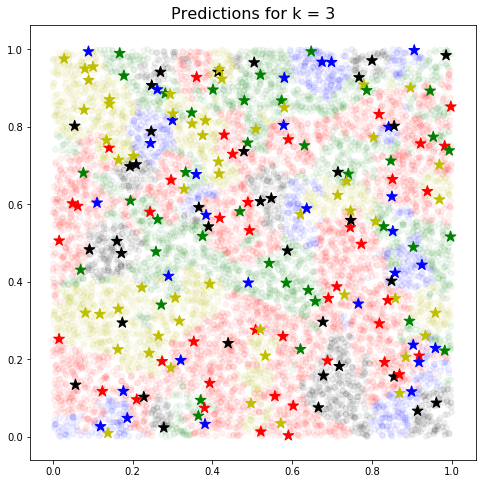

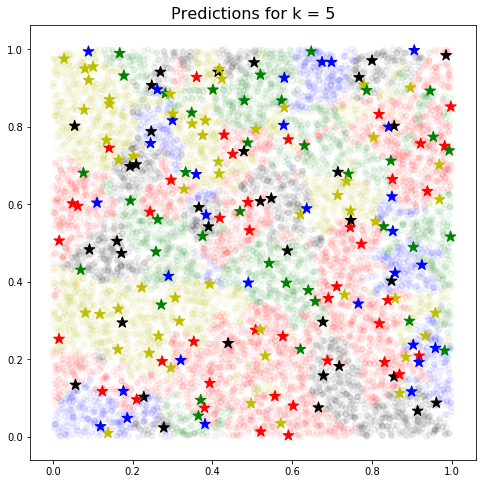

In [27]:
#from knn import KnnClassifier

num_test = 10000
num_train = 200
num_classes = 5

# Generate random training and test data
torch.manual_seed(128)
x_train = torch.rand(num_train, 2)
y_train = torch.randint(num_classes, size=(num_train,))
x_test = torch.rand(num_test, 2)
classifier = KnnClassifier(x_train, y_train)

# Plot predictions for different values of k
for k in [1, 3, 5]:
    y_test = classifier.predict(x_test, k=k)
    plt.gcf().set_size_inches(8, 8)
    class_colors = ['r', 'g', 'b', 'k', 'y']
    train_colors = [class_colors[c] for c in y_train]
    test_colors = [class_colors[c] for c in y_test]
    plt.scatter(x_test[:, 0], x_test[:, 1],
                color=test_colors, marker='o', s=32, alpha=0.05)
    plt.scatter(x_train[:, 0], x_train[:, 1],
                color=train_colors, marker='*', s=128.0)
    plt.title('Predictions for k = %d' % k, size=16)
    plt.show()

We can use the exact same KNN code to perform image classification on CIFAR-10!

Now lets put everything together and test our K-NN clasifier on a subset of CIFAR-10, using k=1:

If you've implemented everything correctly you should see an accuracy of about 27%.

In [18]:
#from knn import KnnClassifier

torch.manual_seed(0)
num_train = 5000
num_test = 500
x_train, y_train, x_test, y_test = eecs598.data.cifar10(num_train, num_test)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=1)

Got 137 / 500 correct; accuracy is 27.40%


27.4

Now lets increase to k=5. You should see a slightly higher accuracy than k=1:

In [36]:
#from knn import KnnClassifier

torch.manual_seed(0)
num_train = 5000
num_test = 500
x_train, y_train, x_test, y_test = eecs598.data.cifar10(num_train, num_test)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=7)

Got 137 / 500 correct; accuracy is 27.40%


27.4

## Cross-validation
We have not implemented the full k-Nearest Neighbor classifier, but the choice of $k=5$ was arbitrary. We will use **cross-validation** to set this hyperparameter in a more principled manner.

In the file `knn.py`, implement the function `knn_cross_validate` to perform cross-validation on k.

In [26]:
def knn_cross_validate(x_train, y_train, num_folds=5, k_choices=None):
    if k_choices is None:
    # Use default values
        k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
    # First we divide the training data into num_folds equally-sized folds.
    x_train_folds = []
    y_train_folds = []
    #TODO
    x_train_chunk = x_train.chunk(num_folds, dim = 0)
    y_train_chunk = y_train.chunk(num_folds, dim = 0)
    for i in range(num_folds):
        x_train_folds.append(x_train_chunk[i])  #此时数组中的每个元素是一组张量，即训练集中的一个子集
        y_train_folds.append(y_train_chunk[i])

  # A dictionary holding the accuracies for different values of k that we find
  # when running cross-validation. After running cross-validation,
  # k_to_accuracies[k] should be a list of length num_folds giving the different
  # accuracies we found when trying KnnClassifiers that use k neighbors.
    k_to_accuracies = {}
    
  ##############################################################################
  # TODO: Perform cross-validation to find the best value of k. For each value #
  # of k in k_choices, run the k-nearest-neighbor algorithm num_folds times;   #
  # in each case you'll use all but one fold as training data, and use the     #
  # last fold as a validation set. Store the accuracies for all folds and all  #
  # values in k in k_to_accuracies.   HINT: torch.cat                          #
  ##############################################################################
  # Replace "pass" statement with your code
    for k in k_choices:
        accuracy = []
        for i in range(num_folds):
            x_test_cross = x_train_folds[i]  #从5个分好的子集中选择一个子集作为测试集，数据类型为tensor
            y_test_cross = y_train_folds[i]
            x_train_cross = x_train_folds[:] #复制列表
            y_train_cross = y_train_folds[:]
            del x_train_cross[i]  #删掉测试集，选择其余4个子集作为训练集，这里x_train_cross为list，需用torch.cat将其转成tensor，不然分类器里一些函数会报错，比如用到shape属性时，list没有会报错
            del y_train_cross[i]
            #把list训练集改为tensor
            x_train_cross_tensor = x_train_cross[len(x_train_cross)-1] #先把list里最后一个训练子集付给张量
            y_train_cross_tensor = y_train_cross[len(y_train_cross)-1]
            for j in range(len(x_train_cross)-1): #拼接的时候不用拼最后一个了，所以-1
                x_train_cross_tensor = torch.cat((x_train_cross_tensor, x_train_cross[j]), dim = 0)
                y_train_cross_tensor = torch.cat((y_train_cross_tensor, y_train_cross[j]), dim = 0)
            classifier = KnnClassifier(x_train_cross_tensor, y_train_cross_tensor)
            per_accuracy = classifier.check_accuracy(x_test_cross, y_test_cross, k=k, quiet = True)
            accuracy.append(per_accuracy)
        k_to_accuracies[k] = accuracy
  ##############################################################################
  #                            END OF YOUR CODE                                #
  ##############################################################################

    return k_to_accuracies


In [27]:
#from knn import knn_cross_validate

torch.manual_seed(0)
num_train = 5000
num_test = 500
x_train, y_train, x_test, y_test = eecs598.data.cifar10(num_train, num_test)

k_to_accuracies = knn_cross_validate(x_train, y_train, num_folds=5)

for k, accs in sorted(k_to_accuracies.items()):
  print('k = %d got accuracies: %r' % (k, accs))

k = 1 got accuracies: [26.3, 25.7, 26.4, 27.8, 26.6]
k = 3 got accuracies: [23.9, 24.9, 24.0, 26.6, 25.4]
k = 5 got accuracies: [24.8, 26.6, 28.0, 29.2, 28.0]
k = 8 got accuracies: [26.2, 28.2, 27.3, 29.0, 27.3]
k = 10 got accuracies: [26.5, 29.6, 27.6, 28.4, 28.0]
k = 12 got accuracies: [26.0, 29.5, 27.9, 28.3, 28.0]
k = 15 got accuracies: [25.2, 28.9, 27.8, 28.2, 27.4]
k = 20 got accuracies: [27.0, 27.9, 27.9, 28.2, 28.5]
k = 50 got accuracies: [27.1, 28.8, 27.8, 26.9, 26.6]
k = 100 got accuracies: [25.6, 27.0, 26.3, 25.6, 26.3]


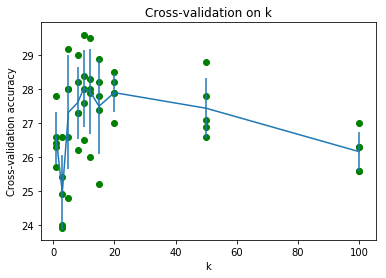

In [28]:
ks, means, stds = [], [], []
torch.manual_seed(0)
for k, accs in sorted(k_to_accuracies.items()):
  plt.scatter([k] * len(accs), accs, color='g')
  ks.append(k)
  means.append(statistics.mean(accs))
  stds.append(statistics.stdev(accs))
plt.errorbar(ks, means, yerr=stds)
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.title('Cross-validation on k')
plt.show()

Now we can use the results of cross-validation to select the best value for k, and rerun the classifier on our full 5000 set of training examples.

You should get an accuracy above 28%.

In [36]:
def knn_get_best_k(k_to_accuracies):

    best_k = 0
  ##############################################################################
  # TODO: Use the results of cross-validation stored in k_to_accuracies to     #
  # choose the value of k, and store the result in best_k. You should choose   #
  # the value of k that has the highest mean accuracy accross all folds.       #
  ##############################################################################
  # Replace "pass" statement with your code
    ks, means = [], []
    for k, accs in sorted(k_to_accuracies.items()):
        ks.append(k)
        means.append(statistics.mean(accs))
    max_index = means.index(max(means))
    best_k = ks[max_index]
  ##############################################################################
  #                            END OF YOUR CODE                                #
  ##############################################################################
    return best_k

In [37]:
#from knn import KnnClassifier
#from knn import knn_get_best_k

best_k = 1
torch.manual_seed(0)

best_k = knn_get_best_k(k_to_accuracies)    
print('Best k is ', best_k)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=best_k)

Best k is  10
Got 141 / 500 correct; accuracy is 28.20%


28.2

Finally, we can use our chosen value of k to run on the entire training and test sets.

This may take a while to run, since the full training and test sets have 50k and 10k examples respectively. You should get an accuracy above 33%.

**Run this only once!**

In [38]:
#from knn import KnnClassifier

torch.manual_seed(0)
x_train_all, y_train_all, x_test_all, y_test_all = eecs598.data.cifar10()
classifier = KnnClassifier(x_train_all, y_train_all)
classifier.check_accuracy(x_test_all, y_test_all, k=best_k)

Got 3386 / 10000 correct; accuracy is 33.86%


33.86

## Submit Your Work
After completing both notebooks for this assignment (`pytorch101.ipynb` and this notebook, `knn.ipynb`), run the following cell to create a `.zip` file for you to download and turn in:

In [ ]:
from eecs598.submit import make_a1_submission

make_a1_submission(GOOGLE_DRIVE_PATH)